In [1]:
import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    Dropout
)

import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,RocCurveDisplay,classification_report,precision_score,recall_score,f1_score
import time
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [26]:
def matrix_confusion(yt, yp,time_taken):
    data = {'Y_Real': yt,
            'Y_Pred': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Pred'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Pred'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()
    y_val = df['Y_Real'].to_numpy()
    predictions = df['Y_Pred'].to_numpy()
    accuracy = accuracy_score(y_val,predictions)
    precision = precision_score(y_val,predictions,average='macro')
    recall = recall_score(y_val,predictions,average='macro')
    f1 = f1_score(y_val,predictions,average='macro')
    print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Total Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    print("Classification Report:\n")
    print(classification_report(y_val,predictions))


    return time_taken,accuracy,precision,recall,f1

In [4]:
torch.cuda.is_available()

True

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize your images as required
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

In [6]:
dataset = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Data/dataset_2/train', transform=transform)

In [7]:
def calculate_channel_stats(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    total_samples = len(loader.dataset)
    mean = torch.zeros(3)  # Initialize mean for RGB channels
    std = torch.zeros(3)   # Initialize standard deviation for RGB channels

    progress_threshold = total_samples // 20  # 5% progress threshold
    progress_count = 0
    progress_percent = 0

    for idx, (data, _) in enumerate(loader, 1):
        img = data.squeeze(0)  # Remove batch dimension (assuming batch_size=1)
        mean += torch.mean(img, dim=(1, 2))  # Compute mean along height and width dimensions
        std += torch.std(img, dim=(1, 2))    # Compute standard deviation along height and width dimensions

        # Check progress after every 5%
        if idx % progress_threshold == 0:
            progress_count += 1
            progress_percent += 5
            print(f"{progress_percent}% of samples processed")

    return mean / total_samples, std / total_samples

# Calculate mean and standard deviation for each channel
# calculated_mean, calculated_std = calculate_channel_stats(dataset)
calculated_mean = torch.tensor([0.5057, 0.5057, 0.5057]) # calculated before
calculated_std = torch.tensor([0.2305, 0.2305, 0.2305])
print("Calculated Mean for R, G, B channels:", calculated_mean)
print("Calculated Standard Deviation for R, G, B channels:", calculated_std)

Calculated Mean for R, G, B channels: tensor([0.5057, 0.5057, 0.5057])
Calculated Standard Deviation for R, G, B channels: tensor([0.2305, 0.2305, 0.2305])


In [8]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(calculated_mean, calculated_std),
])

In [9]:
train_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Data/dataset_2/train', transform=transform)
test_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Data/dataset_2/test', transform=transform)

In [10]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [11]:
dataset_length = len(train_data)
dataset_length

86524

In [68]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [69]:
# Normal (0) and True, Pneumonia (1)
print((train_loader.dataset.class_to_idx))
print((test_loader.dataset.class_to_idx))

{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'No Finding': 10, 'Nodule': 11, 'Pleural_Thickening': 12, 'Pneumonia': 13, 'Pneumothorax': 14}
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'No Finding': 10, 'Nodule': 11, 'Pleural_Thickening': 12, 'Pneumonia': 13, 'Pneumothorax': 14}


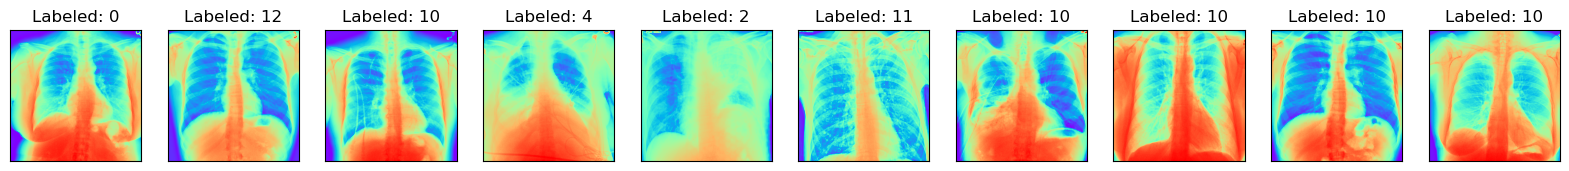

In [71]:
n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

# DeiT

In [72]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


In [73]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15) # 15 classes
)
model = model.to('cuda')
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=15, bias=True)
)


In [74]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [75]:
epochs = 6
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/DeiT model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / dataset_length 
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%\t Time: {time.time()-tic:.2f}s")


toc = time.time()

Saving model with test loss of 58.193
Training [17%]	Loss: 1.5086	Accuracy: 58.19%	 Time: 1464.25s
Saving model with test loss of 58.339
Training [33%]	Loss: 1.4594	Accuracy: 58.34%	 Time: 2921.20s
Saving model with test loss of 58.474
Training [50%]	Loss: 1.4433	Accuracy: 58.47%	 Time: 4429.17s
Saving model with test loss of 58.593
Training [67%]	Loss: 1.4309	Accuracy: 58.59%	 Time: 5894.10s
Saving model with test loss of 58.583
Training [83%]	Loss: 1.4236	Accuracy: 58.58%	 Time: 7346.28s
Saving model with test loss of 58.697
Training [100%]	Loss: 1.4148	Accuracy: 58.70%	 Time: 8812.90s


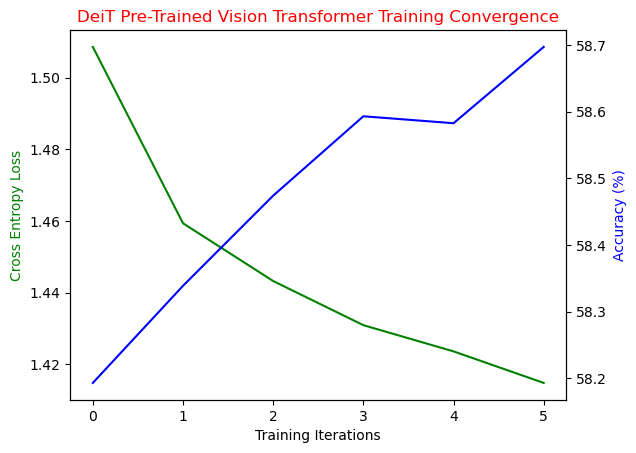

In [76]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("DeiT Pre-Trained Vision Transformer Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [77]:
torch.save(model.state_dict(), model_path2)

In [78]:
model_temp = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
model_temp.head = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15) # 15 classes
)
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


In [79]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 1.8813
	Accuracy: 38.77%
[4, 4, 10, 4, 2, 0, 10, 10, 11, 4, 0, 14, 10, 10, 8, 10, 4, 8, 8, 10, 10, 9, 10, 10, 4, 8, 0, 10, 10, 10, 10, 10, 0, 10, 4, 10, 10, 0, 10, 10, 2, 10, 10, 14, 10, 10, 14, 10, 10, 10, 10, 8, 0, 9, 10, 1, 2, 10, 10, 10, 10, 10, 10, 4, 8, 8, 9, 10, 10, 4, 4, 0, 10, 10, 12, 5, 10, 9, 1, 14, 10, 10, 1, 10, 12, 10, 10, 0, 5, 4, 4, 8, 2, 10, 4, 8, 10, 10, 8, 0, 3, 5, 4, 1, 1, 10, 4, 10, 1, 12, 0, 10, 10, 2, 4, 4, 10, 10, 2, 10, 0, 0, 2, 10, 2, 0, 10, 10, 4, 10, 10, 6, 10, 10, 10, 10, 0, 4, 10, 0, 10, 0, 6, 4, 5, 10, 10, 5, 0, 2, 8, 3, 11, 0, 2, 2, 0, 8, 12, 14, 9, 10, 10, 4, 9, 8, 13, 10, 8, 10, 4, 4, 10, 8, 0, 10, 10, 4, 4, 3, 2, 0, 1, 10, 4, 0, 3, 0, 12, 4, 10, 4, 14, 3, 0, 8, 10, 0, 10, 10, 10, 10, 10, 14, 10, 10, 8, 10, 9, 4, 8, 10, 10, 10, 10, 10, 2, 8, 8, 14, 4, 10, 10, 14, 9, 12, 10, 10, 2, 10, 0, 10, 4, 3, 10, 8, 4, 4, 10, 4, 2, 4, 3, 0, 1, 10, 8, 10, 10, 4, 10, 8, 10, 10, 5, 10, 8, 4, 8, 2, 10, 2, 1, 0, 10, 8, 10, 8, 0, 10, 4, 

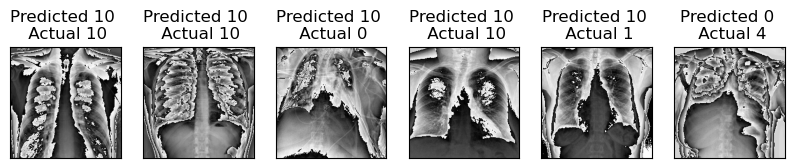

In [80]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [81]:
time_taken = toc-tic

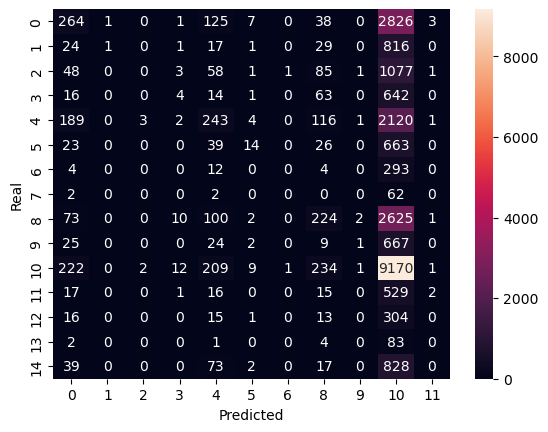

Time taken:  8812.90059375763
Test size: 25596
Total Accuracy:  0.387677762150336
Total Precision:  0.16761318605497158
Total Recall:  0.0803265904121384
Total F1 Score:  0.0662119585040967
Classification Report:

              precision    recall  f1-score   support

           0       0.27      0.08      0.12      3265
           1       0.50      0.00      0.00       889
           2       0.00      0.00      0.00      1275
           3       0.12      0.01      0.01       740
           4       0.26      0.09      0.13      2679
           5       0.32      0.02      0.03       765
           6       0.00      0.00      0.00       313
           7       0.00      0.00      0.00        66
           8       0.26      0.07      0.11      3037
           9       0.17      0.00      0.00       728
          10       0.40      0.93      0.56      9861
          11       0.22      0.00      0.01       580
          12       0.00      0.00      0.00       349
          13       0.00      

c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

In [82]:
val_diet = matrix_confusion(test_targets, pred_targets,time_taken)

In [83]:
outdiet = pd.DataFrame([val_diet],
                   index = ['DieT Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
outdiet.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
DieT Model,8812.900594,0.387678,0.167613,0.080327,0.066212


In [84]:
import pickle

In [85]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/outputDieTModel.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(outdiet, file)
    print("Data Stored Successfully")

Data Stored Successfully


# ResNet50

In [86]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [87]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15) # 15 classes
)
model = model.to('cuda')
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=15, bias=True)
)


In [88]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [89]:
epochs = 6
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/ResNet50 model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / dataset_length 
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%\t Time: {time.time()-tic:.2f}s")


toc = time.time()

Saving model with test loss of 58.265
Training [17%]	Loss: 1.5112	Accuracy: 58.26%	 Time: 1622.81s
Saving model with test loss of 58.412
Training [33%]	Loss: 1.4688	Accuracy: 58.41%	 Time: 3242.41s
Saving model with test loss of 58.469
Training [50%]	Loss: 1.4564	Accuracy: 58.47%	 Time: 4863.35s
Saving model with test loss of 58.503
Training [67%]	Loss: 1.4476	Accuracy: 58.50%	 Time: 6483.39s
Saving model with test loss of 58.553
Training [83%]	Loss: 1.4428	Accuracy: 58.55%	 Time: 8110.84s
Saving model with test loss of 58.570
Training [100%]	Loss: 1.4359	Accuracy: 58.57%	 Time: 9740.34s


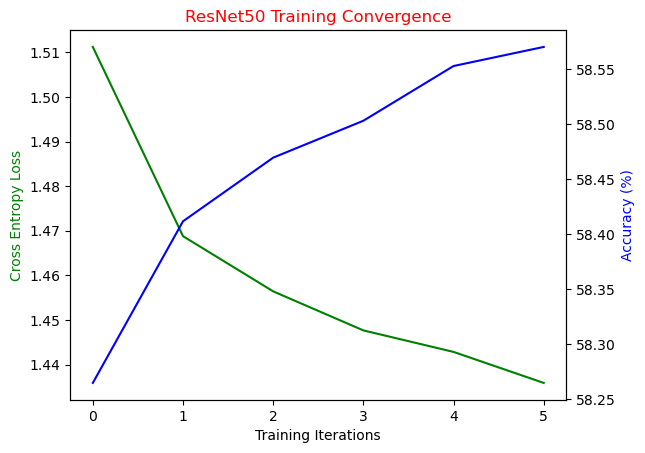

In [90]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("ResNet50 Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [91]:
torch.save(model.state_dict(), model_path2)

In [92]:
model_temp = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model_temp.fc = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15) # 15 classes
)
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0


In [93]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 1.8899
	Accuracy: 39.02%
[0, 4, 10, 9, 2, 10, 10, 10, 10, 8, 6, 9, 10, 2, 3, 10, 10, 10, 10, 8, 11, 0, 0, 8, 11, 6, 5, 4, 14, 10, 2, 10, 10, 10, 10, 10, 7, 4, 10, 10, 10, 1, 10, 8, 4, 8, 10, 10, 1, 8, 8, 8, 0, 9, 0, 10, 10, 0, 4, 9, 8, 0, 2, 5, 14, 5, 8, 1, 10, 10, 0, 10, 10, 10, 14, 9, 5, 4, 4, 10, 1, 6, 12, 10, 10, 10, 10, 8, 10, 8, 14, 10, 0, 10, 10, 10, 0, 10, 1, 3, 10, 10, 8, 10, 10, 3, 11, 14, 2, 0, 6, 8, 10, 14, 10, 10, 10, 5, 2, 10, 10, 10, 10, 10, 10, 9, 0, 11, 6, 10, 3, 10, 10, 0, 4, 6, 8, 4, 8, 10, 8, 0, 4, 0, 10, 12, 10, 10, 10, 10, 10, 10, 12, 3, 10, 1, 11, 8, 0, 6, 0, 10, 10, 4, 10, 8, 4, 10, 4, 10, 10, 14, 8, 10, 14, 14, 10, 8, 10, 0, 0, 8, 0, 10, 10, 1, 4, 0, 2, 10, 2, 10, 10, 10, 10, 10, 4, 10, 10, 3, 10, 2, 14, 2, 0, 0, 4, 7, 4, 12, 0, 14, 2, 10, 10, 10, 5, 4, 10, 10, 10, 2, 2, 6, 12, 10, 4, 10, 14, 9, 0, 9, 6, 0, 10, 10, 2, 0, 2, 8, 8, 2, 10, 8, 10, 1, 10, 10, 10, 8, 8, 0, 1, 0, 3, 8, 5, 9, 5, 8, 9, 8, 2, 4, 10, 4, 10, 3, 0, 10, 10, 3

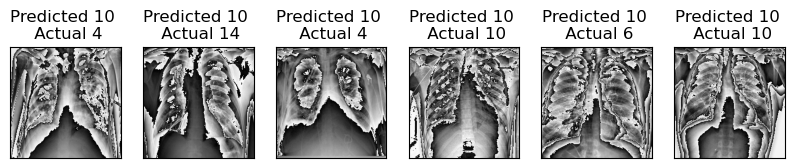

In [94]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [95]:
time_taken = toc-tic

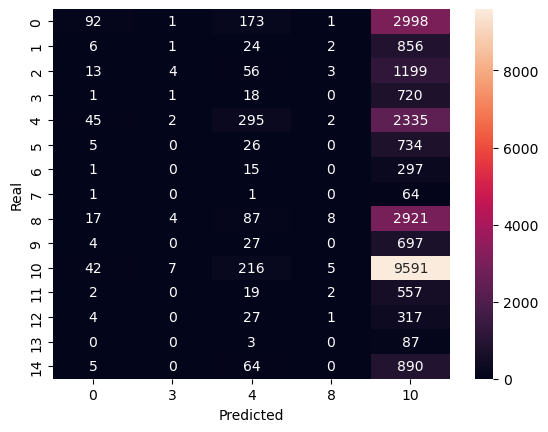

Time taken:  9740.341128110886
Test size: 25596
Total Accuracy:  0.3901781528363807
Total Precision:  0.09639108412575735
Total Recall:  0.07432655307239842
Total F1 Score:  0.05204588941638853
Classification Report:

              precision    recall  f1-score   support

           0       0.39      0.03      0.05      3265
           1       0.00      0.00      0.00       889
           2       0.00      0.00      0.00      1275
           3       0.05      0.00      0.00       740
           4       0.28      0.11      0.16      2679
           5       0.00      0.00      0.00       765
           6       0.00      0.00      0.00       313
           7       0.00      0.00      0.00        66
           8       0.33      0.00      0.01      3037
           9       0.00      0.00      0.00       728
          10       0.40      0.97      0.56      9861
          11       0.00      0.00      0.00       580
          12       0.00      0.00      0.00       349
          13       0.00  

c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

In [96]:
valres = matrix_confusion(test_targets, pred_targets,time_taken)

In [97]:
out = pd.DataFrame([valres],
                   index = ['ResNet50 Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
ResNet50 Model,9740.341128,0.390178,0.096391,0.074327,0.052046


In [98]:
import pickle

In [99]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/ResNet50.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully


# GoogLeNet

In [100]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [101]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.fc.in_features
model.fc = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15) # 15 classes
)
model = model.to('cuda')
print(model.fc)

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=15, bias=True)
)


In [102]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [103]:
epochs = 6
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/googlenet model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / dataset_length 
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%\t Time: {time.time()-tic:.2f}s")


toc = time.time()

Saving model with test loss of 58.220
Training [17%]	Loss: 1.5161	Accuracy: 58.22%	 Time: 1492.63s
Saving model with test loss of 58.247
Training [33%]	Loss: 1.4740	Accuracy: 58.25%	 Time: 2988.17s
Saving model with test loss of 58.320
Training [50%]	Loss: 1.4616	Accuracy: 58.32%	 Time: 4494.72s
Saving model with test loss of 58.377
Training [67%]	Loss: 1.4540	Accuracy: 58.38%	 Time: 5985.35s
Saving model with test loss of 58.444
Training [83%]	Loss: 1.4488	Accuracy: 58.44%	 Time: 7461.88s
Saving model with test loss of 58.475
Training [100%]	Loss: 1.4430	Accuracy: 58.48%	 Time: 8956.02s


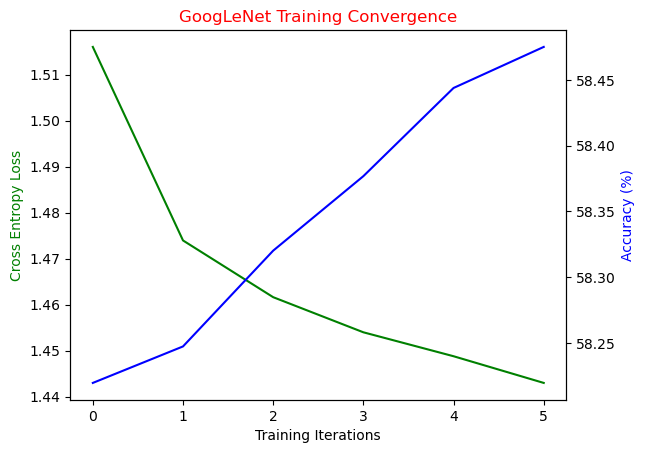

In [104]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("GoogLeNet Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [105]:
torch.save(model.state_dict(), model_path2)

In [106]:
model_temp = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_temp.fc = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15) # 15 classes
)
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0


In [107]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 1.8830
	Accuracy: 38.83%
[1, 8, 10, 4, 9, 0, 11, 9, 4, 5, 10, 2, 10, 3, 4, 10, 14, 4, 4, 10, 10, 10, 4, 12, 10, 10, 11, 2, 0, 10, 10, 10, 10, 10, 10, 0, 8, 10, 9, 4, 10, 8, 0, 14, 10, 4, 8, 2, 0, 10, 10, 14, 10, 10, 8, 5, 10, 14, 14, 0, 10, 4, 2, 0, 0, 2, 10, 8, 10, 4, 10, 5, 0, 0, 10, 0, 0, 2, 4, 1, 10, 8, 10, 10, 11, 10, 10, 10, 10, 1, 3, 10, 4, 4, 10, 2, 4, 8, 9, 2, 8, 4, 0, 4, 10, 10, 1, 10, 0, 0, 4, 2, 10, 4, 10, 3, 2, 11, 9, 11, 14, 11, 10, 4, 4, 10, 2, 10, 5, 10, 8, 1, 10, 2, 2, 10, 2, 11, 10, 11, 8, 3, 4, 10, 10, 9, 8, 5, 0, 9, 10, 3, 10, 10, 4, 0, 8, 10, 0, 0, 8, 3, 0, 6, 10, 10, 0, 14, 5, 10, 12, 10, 9, 10, 8, 10, 4, 1, 0, 2, 3, 10, 8, 2, 10, 2, 10, 10, 4, 0, 2, 6, 10, 10, 12, 4, 10, 10, 8, 8, 12, 4, 14, 0, 12, 10, 4, 8, 10, 10, 1, 10, 8, 10, 0, 8, 8, 10, 10, 0, 4, 12, 10, 10, 0, 8, 2, 0, 8, 5, 0, 0, 0, 4, 3, 8, 8, 0, 10, 5, 10, 8, 0, 0, 10, 10, 10, 5, 10, 3, 0, 4, 0, 10, 10, 10, 10, 3, 10, 8, 0, 4, 10, 10, 2, 8, 10, 14, 4, 10, 4, 10, 10, 10, 

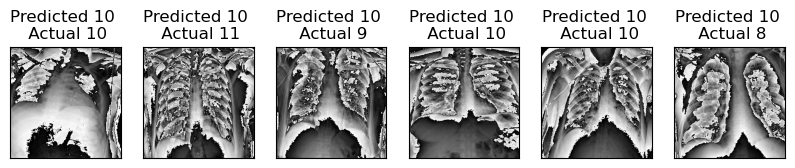

In [108]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [109]:
time_taken = toc-tic

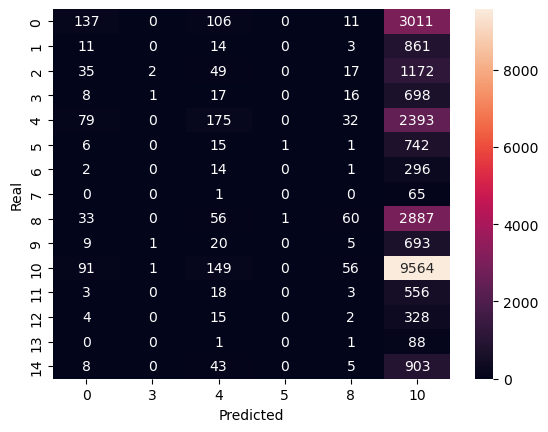

Time taken:  8956.019262075424
Test size: 25596
Total Accuracy:  0.3882637912173777
Total Precision:  0.13000597185934132
Total Recall:  0.07330528637340301
Total F1 Score:  0.05205921801810704
Classification Report:

              precision    recall  f1-score   support

           0       0.32      0.04      0.07      3265
           1       0.00      0.00      0.00       889
           2       0.00      0.00      0.00      1275
           3       0.20      0.00      0.00       740
           4       0.25      0.07      0.10      2679
           5       0.50      0.00      0.00       765
           6       0.00      0.00      0.00       313
           7       0.00      0.00      0.00        66
           8       0.28      0.02      0.04      3037
           9       0.00      0.00      0.00       728
          10       0.39      0.97      0.56      9861
          11       0.00      0.00      0.00       580
          12       0.00      0.00      0.00       349
          13       0.00  

c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

In [110]:
valgoog = matrix_confusion(test_targets, pred_targets,time_taken)

In [111]:
out = pd.DataFrame([valgoog],
                   index = ['GoogLeNet Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
GoogLeNet Model,8956.019262,0.388264,0.130006,0.073305,0.052059


In [112]:
import pickle

In [113]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/googlenet.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully


# VGG19

In [114]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [115]:
for param in model.parameters(): #freeze model
    param.requires_grad = False
print(model.classifier)
classifier_indices = [i for i, layer in enumerate(model.classifier) if isinstance(layer, Linear)]
last_fc_index = classifier_indices[-1] if classifier_indices else None

# Define your custom model head
n_inputs = model.classifier[last_fc_index].in_features  # Number of input features for your new layers
modelhead = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15)  # 15 classes in the final output layer
)
model.classifier = Sequential(
        *list(model.classifier.children())[:-1],  # Remove the last fully connected layer
        modelhead  # Append your custom model head
    )
    
print(model)
model = model.to('cuda')


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

In [116]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [117]:
epochs = 6
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/vgg19 model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / dataset_length 
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%\t Time: {time.time()-tic:.2f}s")


toc = time.time()

Saving model with test loss of 58.225
Training [17%]	Loss: 1.5296	Accuracy: 58.23%	 Time: 2171.27s
Saving model with test loss of 58.345
Training [33%]	Loss: 1.5036	Accuracy: 58.34%	 Time: 4339.77s
Saving model with test loss of 58.328
Training [50%]	Loss: 1.4968	Accuracy: 58.33%	 Time: 6509.44s
Saving model with test loss of 58.342
Training [67%]	Loss: 1.4913	Accuracy: 58.34%	 Time: 8677.74s
Saving model with test loss of 58.348
Training [83%]	Loss: 1.4892	Accuracy: 58.35%	 Time: 10845.24s
Saving model with test loss of 58.355
Training [100%]	Loss: 1.4843	Accuracy: 58.35%	 Time: 13012.02s


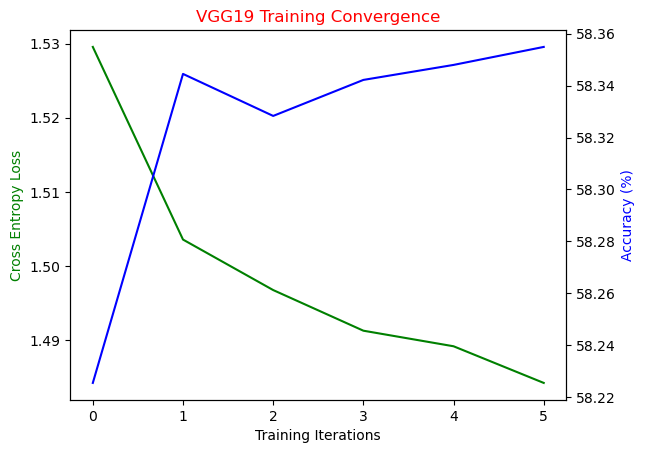

In [118]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("VGG19 Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [119]:
torch.save(model.state_dict(), model_path2)

In [120]:
model_temp = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True) 
model_temp.classifier = Sequential(
        *list(model_temp.classifier.children())[:-1],  # Remove the last fully connected layer
        modelhead  # Append your custom model head
    ) 

model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0


In [121]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 1.9076
	Accuracy: 38.41%
[10, 3, 8, 9, 10, 0, 12, 0, 10, 4, 0, 10, 8, 8, 2, 10, 5, 5, 14, 12, 4, 10, 0, 10, 8, 8, 10, 1, 10, 2, 2, 4, 4, 10, 0, 10, 4, 8, 10, 10, 8, 11, 4, 1, 10, 2, 10, 10, 6, 0, 10, 0, 10, 10, 0, 0, 10, 8, 0, 10, 10, 8, 8, 8, 4, 0, 10, 10, 10, 10, 10, 0, 8, 11, 0, 10, 10, 0, 10, 8, 4, 6, 10, 8, 10, 4, 1, 14, 0, 10, 4, 2, 10, 1, 4, 3, 4, 10, 11, 0, 11, 10, 3, 11, 2, 0, 10, 6, 14, 10, 4, 10, 10, 10, 0, 8, 2, 10, 4, 8, 3, 8, 4, 10, 3, 8, 1, 3, 0, 5, 10, 0, 8, 10, 4, 2, 0, 14, 10, 10, 14, 4, 10, 10, 0, 0, 0, 0, 1, 10, 0, 10, 2, 0, 0, 10, 9, 10, 1, 10, 4, 10, 2, 0, 10, 14, 0, 10, 10, 10, 3, 10, 5, 3, 4, 5, 10, 10, 10, 10, 4, 1, 6, 0, 3, 0, 10, 0, 10, 0, 4, 10, 2, 10, 10, 8, 10, 8, 2, 10, 8, 8, 0, 10, 4, 14, 4, 10, 3, 10, 4, 9, 10, 10, 0, 2, 1, 8, 10, 4, 10, 10, 0, 10, 4, 4, 11, 10, 10, 10, 10, 8, 8, 2, 11, 10, 2, 0, 4, 0, 10, 10, 10, 8, 8, 8, 10, 2, 10, 9, 10, 11, 10, 0, 10, 0, 10, 1, 9, 10, 10, 12, 10, 0, 10, 8, 8, 8, 10, 10, 10, 4, 5, 11,

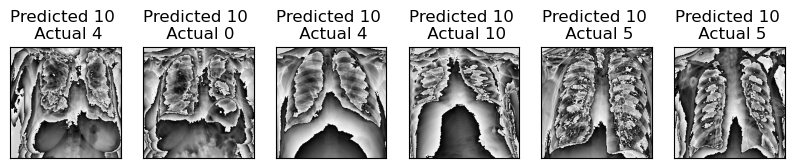

In [122]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [123]:
time_taken = toc-tic

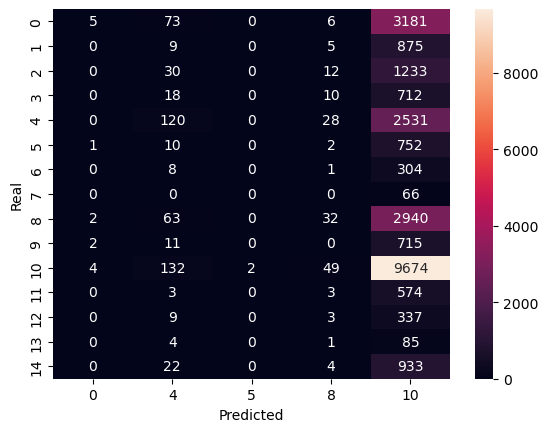

Time taken:  13012.023785352707
Test size: 25596
Total Accuracy:  0.3840834505391467
Total Precision:  0.0789981981997878
Total Recall:  0.06919315644141463
Total F1 Score:  0.043647586435399365
Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.00      0.00      3265
           1       0.00      0.00      0.00       889
           2       0.00      0.00      0.00      1275
           3       0.00      0.00      0.00       740
           4       0.23      0.04      0.08      2679
           5       0.00      0.00      0.00       765
           6       0.00      0.00      0.00       313
           7       0.00      0.00      0.00        66
           8       0.21      0.01      0.02      3037
           9       0.00      0.00      0.00       728
          10       0.39      0.98      0.56      9861
          11       0.00      0.00      0.00       580
          12       0.00      0.00      0.00       349
          13       0.00 

c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

In [124]:
valvgg = matrix_confusion(test_targets, pred_targets,time_taken)

In [125]:
out = pd.DataFrame([valvgg],
                   index = ['VGG19 Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
VGG19 Model,13012.023785,0.384083,0.078998,0.069193,0.043648


In [126]:
import pickle

In [127]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/vgg19.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully


# DenseNet 121

In [128]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rjuya\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [129]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.classifier.in_features
modelhead = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15) # 15 classes
)
model.classifier = modelhead
model = model.to('cuda')
print(model.classifier)

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=15, bias=True)
)


In [130]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [131]:
epochs = 6
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/densenet121 model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / dataset_length 
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%\t Time: {time.time()-tic:.2f}s")


toc = time.time()

Saving model with test loss of 58.317
Training [17%]	Loss: 1.5021	Accuracy: 58.32%	 Time: 1611.79s
Saving model with test loss of 58.467
Training [33%]	Loss: 1.4549	Accuracy: 58.47%	 Time: 3221.70s
Saving model with test loss of 58.663
Training [50%]	Loss: 1.4393	Accuracy: 58.66%	 Time: 4829.84s
Saving model with test loss of 58.697
Training [67%]	Loss: 1.4281	Accuracy: 58.70%	 Time: 6443.82s
Saving model with test loss of 58.719
Training [83%]	Loss: 1.4204	Accuracy: 58.72%	 Time: 8050.63s
Saving model with test loss of 58.758
Training [100%]	Loss: 1.4133	Accuracy: 58.76%	 Time: 9663.20s


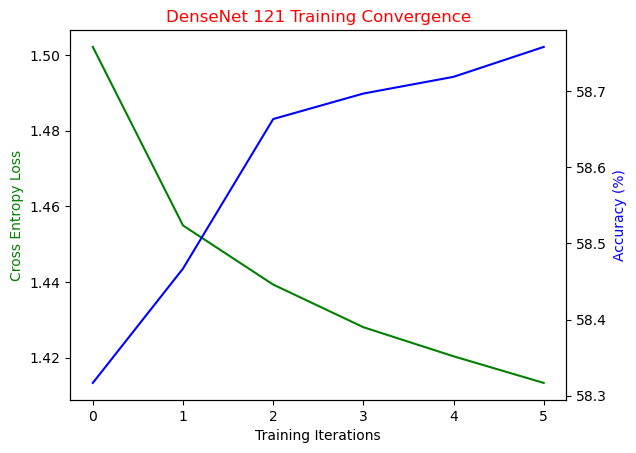

In [132]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("DenseNet 121 Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [133]:
torch.save(model.state_dict(), model_path2)

In [134]:
model_temp = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model_temp.classifier = modelhead
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\pytorch_vision_v0.10.0


In [135]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 1.8711
	Accuracy: 38.46%
[10, 0, 10, 10, 10, 3, 4, 10, 9, 10, 10, 10, 5, 0, 8, 10, 10, 0, 8, 0, 14, 8, 2, 0, 8, 10, 8, 10, 10, 1, 0, 0, 11, 4, 10, 10, 8, 8, 0, 10, 12, 0, 10, 10, 8, 10, 0, 10, 0, 8, 5, 0, 10, 1, 4, 0, 8, 10, 10, 0, 14, 9, 8, 4, 10, 10, 10, 0, 10, 4, 8, 0, 10, 8, 10, 10, 10, 10, 10, 0, 6, 2, 14, 10, 0, 11, 10, 10, 3, 10, 9, 10, 3, 13, 9, 10, 8, 8, 8, 10, 4, 10, 10, 0, 10, 14, 0, 10, 1, 10, 5, 4, 3, 14, 0, 10, 6, 4, 4, 10, 10, 0, 0, 4, 4, 8, 3, 9, 4, 8, 10, 10, 10, 0, 14, 10, 2, 4, 3, 1, 10, 4, 4, 9, 0, 0, 4, 1, 8, 4, 10, 5, 0, 4, 2, 3, 10, 10, 4, 8, 0, 1, 4, 10, 10, 8, 8, 4, 10, 12, 10, 0, 3, 11, 10, 2, 10, 10, 10, 10, 4, 3, 1, 5, 8, 12, 4, 5, 10, 6, 12, 0, 10, 4, 10, 12, 0, 10, 8, 10, 14, 8, 10, 10, 8, 2, 4, 0, 4, 10, 4, 9, 4, 4, 0, 10, 10, 10, 0, 10, 5, 10, 8, 10, 10, 10, 8, 8, 4, 10, 10, 0, 10, 10, 0, 10, 10, 11, 0, 9, 10, 1, 10, 10, 8, 10, 10, 10, 4, 10, 10, 10, 2, 8, 10, 4, 4, 10, 10, 10, 14, 10, 0, 10, 1, 10, 10, 0, 4, 4, 12, 10, 1

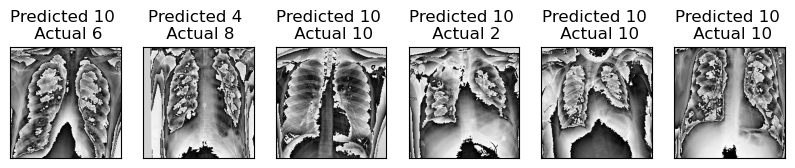

In [136]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [137]:
time_taken = toc-tic

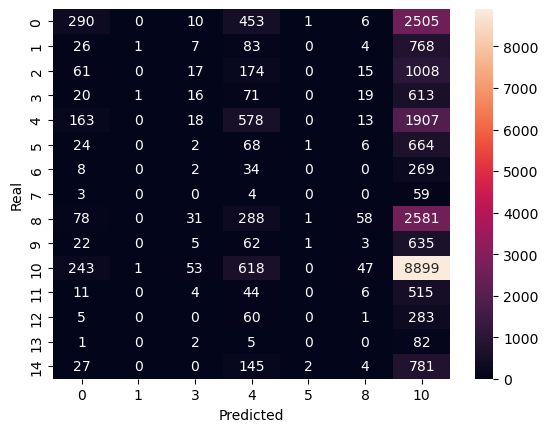

Time taken:  9663.202121257782
Test size: 25596
Total Accuracy:  0.3845522737927801
Total Precision:  0.1224998697087979
Total Recall:  0.0833445605938449
Total F1 Score:  0.06629500705632402
Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.09      0.14      3265
           1       0.33      0.00      0.00       889
           2       0.00      0.00      0.00      1275
           3       0.10      0.02      0.04       740
           4       0.22      0.22      0.22      2679
           5       0.17      0.00      0.00       765
           6       0.00      0.00      0.00       313
           7       0.00      0.00      0.00        66
           8       0.32      0.02      0.04      3037
           9       0.00      0.00      0.00       728
          10       0.41      0.90      0.57      9861
          11       0.00      0.00      0.00       580
          12       0.00      0.00      0.00       349
          13       0.00    

c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

In [138]:
valdense = matrix_confusion(test_targets, pred_targets,time_taken)

In [139]:
out = pd.DataFrame([valdense],
                   index = ['DenseNet 121 Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
DenseNet 121 Model,9663.202121,0.384552,0.1225,0.083345,0.066295


In [140]:
import pickle

In [141]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/densenet121.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully


# EfficientNet

In [142]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\rjuya/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\rjuya/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [143]:
for param in model.parameters(): #freeze model
    param.requires_grad = False
print(model.classifier)
classifier_indices = [i for i, layer in enumerate(model.classifier) if isinstance(layer, Linear)]
last_fc_index = classifier_indices[-1] if classifier_indices else None

# Define your custom model head
n_inputs = model.classifier[last_fc_index].in_features  # Number of input features for your new layers
modelhead = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 15)  # 15 classes in the final output layer
)
model.classifier = Sequential(
        *list(model.classifier.children())[:-1],  # Remove the last fully connected layer
        modelhead  # Append your custom model head
    )
    
print(model)
model = model.to('cuda')


Sequential(
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (squeeze): Flatten()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1280, out_features=1000, bias=True)
)
EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_featu

In [144]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [145]:
epochs = 6
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/effnetb0 model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / dataset_length 
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%\t Time: {time.time()-tic:.2f}s")

toc = time.time()

Saving model with test loss of 58.399
Training [17%]	Loss: 1.5152	Accuracy: 58.40%	 Time: 1446.70s
Saving model with test loss of 58.680
Training [33%]	Loss: 1.4453	Accuracy: 58.68%	 Time: 2913.32s
Saving model with test loss of 58.869
Training [50%]	Loss: 1.4240	Accuracy: 58.87%	 Time: 4386.32s
Saving model with test loss of 58.885
Training [67%]	Loss: 1.4106	Accuracy: 58.89%	 Time: 5860.00s
Saving model with test loss of 58.987
Training [83%]	Loss: 1.3980	Accuracy: 58.99%	 Time: 7331.25s
Saving model with test loss of 59.098
Training [100%]	Loss: 1.3872	Accuracy: 59.10%	 Time: 8805.34s


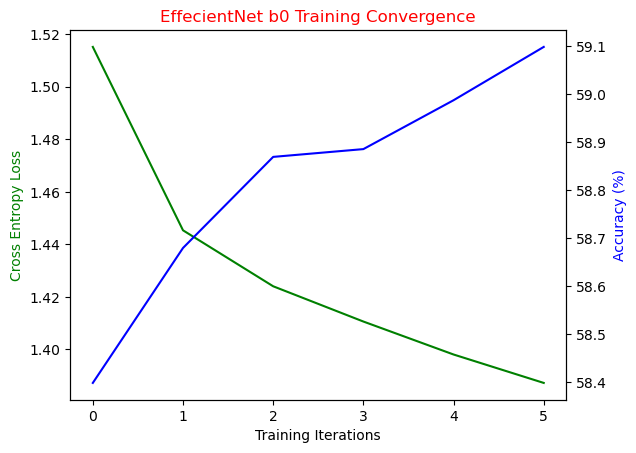

In [146]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("EffecientNet b0 Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [147]:
torch.save(model.state_dict(), model_path2)

In [148]:
model_temp = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model_temp.classifier = Sequential(
        *list(model_temp.classifier.children())[:-1],  # Remove the last fully connected layer
        modelhead  # Append your custom model head
    ) 
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [149]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 1.8751
	Accuracy: 38.92%
[10, 10, 10, 8, 0, 10, 10, 10, 4, 2, 2, 5, 4, 10, 9, 8, 11, 0, 14, 14, 3, 1, 0, 10, 1, 10, 10, 4, 3, 9, 6, 3, 0, 2, 8, 8, 0, 8, 2, 8, 11, 3, 10, 14, 10, 10, 0, 8, 10, 10, 4, 0, 4, 10, 10, 2, 1, 10, 4, 10, 0, 10, 4, 4, 10, 10, 14, 10, 10, 0, 14, 8, 14, 9, 14, 9, 10, 8, 10, 10, 10, 1, 4, 10, 10, 0, 10, 0, 10, 2, 10, 11, 1, 2, 4, 0, 10, 10, 10, 2, 8, 3, 2, 10, 2, 10, 1, 11, 10, 10, 0, 8, 10, 10, 6, 0, 8, 8, 10, 3, 2, 4, 4, 0, 1, 0, 10, 5, 4, 4, 1, 0, 10, 10, 11, 10, 2, 10, 2, 3, 7, 10, 9, 9, 10, 4, 9, 2, 11, 10, 2, 10, 3, 1, 10, 3, 14, 10, 10, 4, 4, 12, 10, 2, 10, 10, 10, 14, 10, 11, 10, 10, 5, 10, 8, 2, 0, 0, 10, 8, 9, 1, 4, 5, 10, 5, 0, 9, 2, 10, 2, 4, 10, 11, 8, 8, 0, 0, 13, 0, 10, 10, 10, 10, 4, 10, 10, 10, 10, 8, 11, 10, 10, 4, 8, 10, 10, 5, 10, 9, 10, 10, 2, 8, 2, 10, 0, 10, 3, 10, 0, 4, 5, 6, 4, 10, 1, 10, 10, 1, 4, 10, 10, 2, 13, 10, 0, 10, 8, 0, 4, 10, 5, 10, 10, 9, 10, 5, 4, 10, 8, 10, 10, 1, 2, 10, 2, 0, 4, 8, 10, 6, 10,

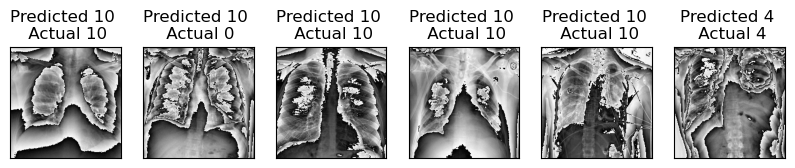

In [150]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [151]:
time_taken = toc-tic

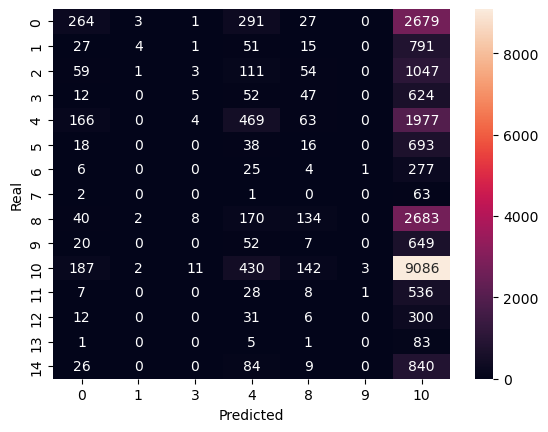

Time taken:  8805.33631324768
Test size: 25596
Total Accuracy:  0.3892014377246445
Total Precision:  0.11400303910043376
Total Recall:  0.08218061013741391
Total F1 Score:  0.06649939760545154
Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.08      0.13      3265
           1       0.33      0.00      0.01       889
           2       0.00      0.00      0.00      1275
           3       0.15      0.01      0.01       740
           4       0.26      0.18      0.21      2679
           5       0.00      0.00      0.00       765
           6       0.00      0.00      0.00       313
           7       0.00      0.00      0.00        66
           8       0.25      0.04      0.08      3037
           9       0.00      0.00      0.00       728
          10       0.41      0.92      0.56      9861
          11       0.00      0.00      0.00       580
          12       0.00      0.00      0.00       349
          13       0.00   

c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rjuya\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

In [152]:
valeff = matrix_confusion(test_targets, pred_targets,time_taken)

In [153]:
out = pd.DataFrame([valeff],
                   index = ['EfficientNet b0 Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
EfficientNet b0 Model,8805.336313,0.389201,0.114003,0.082181,0.066499


In [154]:
import pickle

In [155]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/dataset2/effnetb0.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(out, file)
    print("Data Stored Successfully")

Data Stored Successfully
